# Language Translation with nn.Transformer and torchtext

Based on the tutorial: https://pytorch.org/tutorials/beginner/translation_transformer.html

This notebook provides an introduction to language translation using the `nn.Transformer` module and `torchtext` in PyTorch. It demonstrates how to build and train a transformer model to translate sentences from German to English using the Multi30k dataset.

The dataset is loaded using `torchtext.datasets.Multi30k` and tokenized using the `spacy` library. The data is then processed to build vocabularies for both the source (German) and target (English) languages. The processed data is split into training and validation sets, which are loaded using `DataLoader` with a specified batch size.

A transformer model is defined using `torch.nn.Transformer`, consisting of an encoder and a decoder. The model is trained using the Adam optimizer and cross-entropy loss function. The training loop iterates over the dataset for a specified number of epochs, updating the model parameters to minimize the loss.

Additionally, the notebook includes code to save the trained model's state dictionary to a file and load it back for inference. This allows for the model to be reused without retraining.

The notebook concludes with a section on visualizing the model's translations for a sentence provided by user input, offering a qualitative assessment of the model's performance.

Most of the boilerplate for the training is handled by the manager class. This includes printing metrics during training and periodically saving the model, allowing training to be resumed from the last checkpoint.

The manager executes the model by passing only the input (because the target should not be passed by default). To allow passing the target (the model uses the target, except for the last token, because it iterates over the tokens to try to generate the next token), the collation function was changed to return a list of tuples `text_input/target_input` to be used by the executor. Furthermore, the `pad_sequence` used in the original tutorial outputs a tensor in which the first dimension corresponds to the tokens and not the batch items (which became the second dimension), but the manager expects a tuple of lists or tensors in which the length corresponds to the batch length (the loss and accuracy metrics are calculated per record, because the last batch may not be full and would have an incorrect weight over those metrics if the number of batches was used).

To solve this, the dimensions of the text and target tensors are transposed (dimensions 0 and 1) in the collation function, which determines the batches returned by the dataloader, and then transposed again, using the same dimensions, after separating the inputs and targets. This returns them to their original forms, to then combine in a single tensor (one for the text input, another for the target).

*Important:* The executor expects a batch in which each item in the input corresponds to a record in the dataset. So, a list of tuples `(text, target)` is allowed, but not a tuple of lists `(text[], target[])`. The executor may perform this conversion if necessary (as done in `MyBatchExecutor`).

`MyBatchExecutor` is a custom executor defined in this notebook to handle the specific requirements of processing and running batches of text data through the transformer model. It expects a batch of tuples of `text_input/target_input` sentences, with the `target_input` sentence generated from the target, but without the last token (`EOS_IDX`).

Key Responsibilities of `MyBatchExecutor`:

1. **Input Processing**: Converts the input/target sentences into tensors suitable for the transformer model. This includes tokenizing the sentences, creating source and target tensors, and generating masks required by the transformer.
2. **Model Execution**: Runs the transformer model with the processed input tensors to generate the output translations.
3. **Output Handling**: Processes the model's output to produce the final translated sentences.

A custom loss function was defined that calls `CrossEntropyLoss` under the hood after reshaping the output and target tensors and transposing the target (to have the tokens in dimension 0 and the different items of the batch in dimension 1). This is necessary because the collation function transposes the inputs and targets, but the executor transposes them back. Alternatively, the output of the executor could be transposed again to make dimension 0 correspond to the batch items.

The evaluator, `MyEvaluator`, uses the `greedy_decode` and `translate` functions from the original tutorial. It generates tokens until `EOS_IDX` (end of sentence) is found or the maximum number of tokens is generated, and then returns the corresponding text. The evaluator is called by `manager.evaluate(input)`, where `input` is the text to be translated, and the output is the translated text.

The accuracy calculator class is currently set to always return 0.5 (50%). The original tutorial evaluated only the loss, and not the accuracy, so the accuracy was not considered here. The accuracy calculator can be modified to measure the translation accuracy by comparing the model's translations with the true target sentences. For an example, see the accuracy calculator in [seq2seq_translation.ipynb](./seq2seq_translation.ipynb).

A custom metrics class was used to calculate and display metrics related to the losses, which were then saved to a PDF file (`REPORT_PATH`). You can find implementation examples of various metrics classes in [lib/metrics.py](../lib/metrics.py).

In [1]:
NAME = 'translation_transformer'
SAVE_PATH = f'data/test/train/{NAME}-checkpoint.pth'
REPORT_PATH = f'data/test/train/{NAME}-report.pdf'
DATA_DIR = 'data/multi30k'

In [2]:
import sys
if "../" not in sys.path:
  sys.path.append("../")

In [3]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

### Data Sourcing and Processing

In [4]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import multi30k, Multi30k
from typing import Iterable, List


# We need to modify the URLs for the dataset since the links to the original dataset are broken
# Refer to https://github.com/pytorch/text/issues/1756#issuecomment-1163664163 for more info
multi30k.URL["train"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/training.tar.gz"
multi30k.URL["valid"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/validation.tar.gz"

SRC_LANGUAGE = 'de'
TGT_LANGUAGE = 'en'

# Place-holders
token_transform = {}
vocab_transform = {}

```
pip install -U torchdata
pip install -U spacy
python -m spacy download en_core_web_sm
python -m spacy download de_core_news_sm
```

In [5]:
import typing

token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='de_core_news_sm')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')

# helper function to yield list of tokens
def yield_tokens(data_iter: Iterable, language: str) -> typing.Iterator[str]:
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

    for data_sample in data_iter:
        yield token_transform[language](data_sample[language_index[language]])

# Define special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    # Training data Iterator
    train_iter = Multi30k(
        root=DATA_DIR,
        split='train',
        language_pair=(SRC_LANGUAGE, TGT_LANGUAGE), # type: ignore
    )
    # Create torchtext's Vocab object
    vocab_transform[ln] = build_vocab_from_iterator(
        yield_tokens(train_iter, ln),
        min_freq=1,
        specials=special_symbols,
        special_first=True)

# Set ``UNK_IDX`` as the default index. This index is returned when the token is not found.
# If not set, it throws ``RuntimeError`` when the queried token is not found in the Vocabulary.
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  vocab_transform[ln].set_default_index(UNK_IDX)

### Seq2Seq Network using Transformer

In [6]:
from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer
import math
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# helper Module that adds positional encoding to the token embedding to introduce a notion of word order.
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

# helper Module to convert tensor of input indices into corresponding tensor of token embeddings
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

# Seq2Seq Network
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

In [7]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [8]:
torch.manual_seed(0)

SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

### Collation

In [9]:
from torch.nn.utils.rnn import pad_sequence

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    return torch.cat((
        torch.tensor([BOS_IDX]),
        torch.tensor(token_ids),
        torch.tensor([EOS_IDX]),
    ))

# ``src`` and ``tgt`` language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(
        token_transform[ln], #Tokenization
        vocab_transform[ln], #Numericalization
        tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tensors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src = text_transform[SRC_LANGUAGE](src_sample.rstrip("\n"))
        tgt = text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n"))
        src_batch.append(src)
        tgt_batch.append(tgt)

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)

    src = src_batch.transpose(0, 1).to(DEVICE)
    tgt_input = tgt_batch[:-1, :].transpose(1, 0).to(DEVICE)
    tgt_output = tgt_batch[1:, :].transpose(1, 0).to(DEVICE)

    input = [(src_item, tgt_item) for src_item, tgt_item in zip(src, tgt_input)]

    return input, tgt_output

### Training and Evaluation

In [10]:
from torch.utils.data import DataLoader

train_iter = Multi30k(
    root=DATA_DIR,
    split='train',
    language_pair=(SRC_LANGUAGE, TGT_LANGUAGE), # type: ignore
)
train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

val_iter = Multi30k(
    root=DATA_DIR,
    split='valid',
    language_pair=(SRC_LANGUAGE, TGT_LANGUAGE), # type: ignore
)
val_dataloader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

In [11]:
from auto_mind.supervised.handlers import Evaluator

class MyEvaluator(Evaluator[str, str]):
    def run(self, params) -> str:
        model = typing.cast(Seq2SeqTransformer, params.model)
        input = params.input
        return self.translate(model=model, src_sentence=input)

    # function to generate output sequence using greedy algorithm
    def greedy_decode(
        self,
        model: Seq2SeqTransformer,
        src: torch.Tensor,
        src_mask: torch.Tensor,
        max_len: int,
        start_symbol: int,
    ):
        src = src.to(DEVICE)
        src_mask = src_mask.to(DEVICE)

        memory = model.encode(src, src_mask)
        ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
        for i in range(max_len-1):
            memory = memory.to(DEVICE)
            tgt_mask = (
                generate_square_subsequent_mask(ys.size(0)).type(torch.bool)
            ).to(DEVICE)
            out: torch.Tensor = model.decode(ys, memory, tgt_mask)
            out = out.transpose(0, 1)
            prob = model.generator(out[:, -1])
            _, next_word = torch.max(prob, dim=1)
            next_word = next_word.item()

            ys = torch.cat([
                ys,
                torch.ones(1, 1).type_as(src.data).fill_(next_word),
            ], dim=0)
            if next_word == EOS_IDX:
                break
        return ys

    # actual function to translate input sentence into target language
    def translate(self, model: Seq2SeqTransformer, src_sentence: str):
        model.eval()
        src: torch.Tensor = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1)
        num_tokens = src.shape[0]
        src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)

        tgt_tokens = self.greedy_decode(
            model=model,
            src=src,
            src_mask=src_mask,
            max_len=num_tokens + 5,
            start_symbol=BOS_IDX,
        ).flatten()

        return " ".join(
            vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))
        ).replace("<bos>", "").replace("<eos>", "")


In [12]:
from auto_mind import supervised
from auto_mind.supervised.handlers import BatchAccuracyCalculator, BatchAccuracyParams, BatchExecutor, BatchExecutorParams
from lib.metrics import MainMetrics

class MyBatchExecutor(BatchExecutor[list[tuple[torch.Tensor, torch.Tensor]], torch.Tensor]):
    def run(self, params: BatchExecutorParams[list[tuple[torch.Tensor, torch.Tensor]], torch.Tensor]) -> typing.Any:
        model = params.model
        input = params.input

        src = torch.stack([src for src, _ in input]).transpose(1, 0)
        tgt_input = torch.stack([tgt_in for _, tgt_in in input]).transpose(1, 0)

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits: torch.Tensor = model(
            src,
            tgt_input,
            src_mask,
            tgt_mask,
            src_padding_mask,
            tgt_padding_mask,
            src_padding_mask)

        return logits

    def main_output(self, output: torch.Tensor) -> typing.Any:
        return output

class MyLoss(torch.nn.Module):
    def forward(self, output: torch.Tensor, target: torch.Tensor):
        return loss_fn(output.reshape(-1, output.shape[-1]), target.transpose(1, 0).reshape(-1))

class MyAccuracyCalculator(BatchAccuracyCalculator):
    def run(self, params: BatchAccuracyParams) -> float:
        return 0.5

manager = supervised.Manager(
    data_params=supervised.ManagerDataParams(
        train_dataloader=train_dataloader,
        validation_dataloader=val_dataloader,
        test_dataloader=None,
    ),
    model_params=supervised.ManagerModelParams(
        model=transformer,
        criterion=MyLoss(),
        executor=MyBatchExecutor(),
        use_best=False,
    ),
    optimizer_params=supervised.ManagerOptimizerParams(
        optimizer=optimizer,
        scheduler=None,
        train_early_stopper=None,
        test_early_stopper=None,
    ),
    metrics_params=supervised.ManagerMetricsParams(
        evaluator=MyEvaluator(),
        accuracy_calculator=MyAccuracyCalculator(),
        metrics_calculator=MainMetrics(name=NAME, no_accuracy=True, no_time=True).as_file_plotter(REPORT_PATH),
        batch_interval=True,
        save_every=25,
        print_every=25,
        metric_every=25,
    ),
    config=supervised.ManagerConfig(
        save_path=SAVE_PATH,
        random_seed=0,
        train_hook=None,
    ),
)

Training already completed (18 epochs).


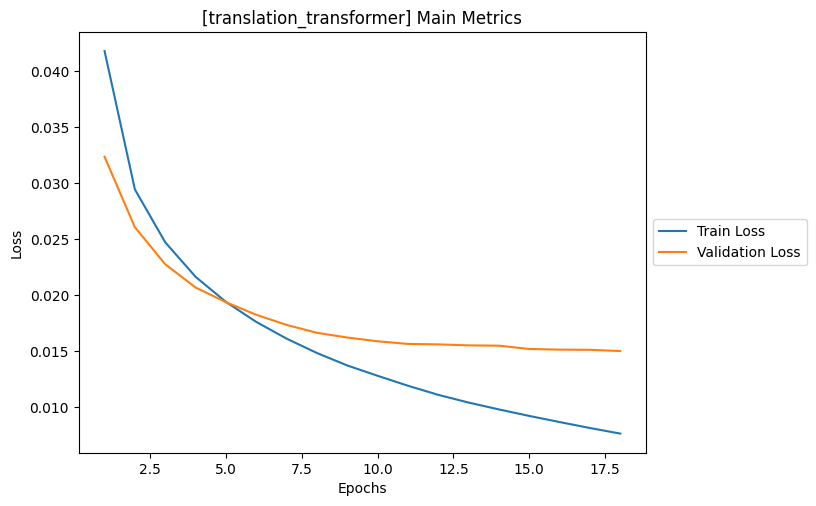

In [13]:
manager.train(epochs=18)

In [14]:
print(manager.evaluate("Eine Gruppe von Menschen steht vor einem Iglu ."))

 A group of people standing in front an igloo 
